## Embeddings

In [1]:
import re, gensim, logging, multiprocessing, datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense

In [2]:
# paths to change
output_path = './salida'

# congig
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
workers = multiprocessing.cpu_count()-1

__process methods__

In [3]:
def expand_contractions(document: str) -> str:
    """
    Replace all abbreviations with their corresponding expansion
    """
    document = re.sub(r"'cause", "because", document)
    document = re.sub(r"o'clock", "of the clock", document)
    document = re.sub(r"won\'t", "will not", document)
    document = re.sub(r"can\'t", "can not", document)
    document = re.sub(r"n\'t", " not", document)
    document = re.sub(r"\'re", " are", document)
    document = re.sub(r"\'s", " is", document)
    document = re.sub(r"\'d", " would", document)
    document = re.sub(r"\'ll", " will", document)
    document = re.sub(r"\'t", " not", document)
    document = re.sub(r"\'ve", " have", document)
    document = re.sub(r"\'m", " am", document)
    return document

In [4]:
def replace_numbers(document: str) -> str:
    """
    Replace number appearances with 'number'
    """
    # Case 1: Combination of numbers and letters (Eg. 2nd -> NUM)
    document = re.sub('[a-zA-Z]+[0-9]+[a-zA-Z]+', 'number', document)
    document = re.sub('[0-9]+[a-zA-Z]+|[a-zA-Z]+[0-9]+', 'number', document)
    # Case 2: Decimal numbers (Eg. 2.1 -> NUM)
    document = re.sub('[0-9]+\.+[0-9]+', 'number', document)
    # Case 3: Numbers between spaces (Eg. 220 888 -> NUM)
    document = re.sub('([0-9]+\s)*[0-9]+', 'number', document)
    # Case 4: One or more of the previous cases (Eg. NUM NUM -> NUM)
    document = re.sub('((NUM)+\s)*(NUM)+', 'number', document)
    return document

In [5]:
def preprocessing(document: str) -> list:
    """
    iterate over all words in document identifing the word and frecuency
    remove all the problematic characters over the word
    and return a dictionary with the word as the key and the frecuency as the value
    """
    document = document.lower()
    document = expand_contractions(document)
    document = replace_numbers(document)
    document = re.sub('[^A-Za-z0-9]+', ' ', document)
    document = document.split()
    return document

In [6]:
def get_sentences() -> pd.DataFrame:
    """
    read and process document
    """
    dataset = datasets.load_dataset('ucberkeley-dlab/measuring-hate-speech', 'binary')   
    df = dataset['train'].to_pandas()
    data = pd.DataFrame()
    data['text'] = df.text
    data['processed'] = df.text.apply(preprocessing)
    data['hatespeech'] = df.hate_speech_score.apply(lambda x: 1 if x > 0 else 0)
    return data

In [7]:
def train_model(size: int, window: int, data: list, epochs: int) -> gensim.models.Word2Vec:
    """
    Train the word2vec embedding
    """
    model = gensim.models.Word2Vec(sentences=data, 
                                   vector_size=size, 
                                   window=window, 
                                   workers=workers, 
                                   min_count=3, 
                                   alpha=0.025, 
                                   min_alpha=0.0007)
    model.build_vocab(data, progress_per=100000)
    model.train(data, total_examples=len(data), epochs=epochs)
    return model

## Create embedding

In [8]:
sentences = get_sentences()
sentences.sample(10)

2022-07-27 18:01:31,431 : WARNING : Using custom data configuration ucberkeley-dlab--measuring-hate-speech-1d47093687320b66
2022-07-27 18:01:31,521 : WARNING : Reusing dataset parquet (C:\Users\Usuario\.cache\huggingface\datasets\ucberkeley-dlab___parquet\ucberkeley-dlab--measuring-hate-speech-1d47093687320b66\0.0.0\7328ef7ee03eaf3f86ae40594d46a1cec86161704e02dd19f232d81eee72ade8)


  0%|          | 0/1 [00:00<?, ?it/s]

,text,processed,hatespeech
1041,Regardless of whether youre sinning or not pra...,"[regardless, of, whether, youre, sinning, or, ...",0
66380,Jamaican is great. I also think women with NY ...,"[jamaican, is, great, i, also, think, women, w...",0
72023,Of course you do sissy DM for sissy training @...,"[of, course, you, do, sissy, dm, for, sissy, t...",1
75900,SHES FUCKING 11 YOU WEIRD ASS BITCH. BABIES SH...,"[shes, fucking, number, you, weird, ass, bitch...",1
20207,And non-muslims also write books on this topic...,"[and, non, muslims, also, write, books, on, th...",0
122548,It's just really pointless and insulting to pe...,"[it, is, just, really, pointless, and, insulti...",0
105801,Fuck you fuck you you stupid cheating bitch go...,"[fuck, you, fuck, you, you, stupid, cheating, ...",1
78095,"look, just because you use a big word doesnt m...","[look, just, because, you, use, a, big, word, ...",0
44962,Bisexuals love a hard dick and a wet pussy URL,"[bisexuals, love, a, hard, dick, and, a, wet, ...",0
26239,I am indian Ingland won the world cup final 💪💪💪,"[i, am, indian, ingland, won, the, world, cup,...",0


In [9]:
#Train embedding
embedding = train_model(size=150, window=3, data=list(sentences['processed']), epochs=20)

2022-07-27 18:01:38,563 : INFO : collecting all words and their counts
2022-07-27 18:01:38,564 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2022-07-27 18:01:38,592 : INFO : PROGRESS: at sentence #10000, processed 260239 words, keeping 19201 word types
2022-07-27 18:01:38,625 : INFO : PROGRESS: at sentence #20000, processed 519498 words, keeping 28373 word types
2022-07-27 18:01:38,653 : INFO : PROGRESS: at sentence #30000, processed 784049 words, keeping 32838 word types
2022-07-27 18:01:38,681 : INFO : PROGRESS: at sentence #40000, processed 1042524 words, keeping 35810 word types
2022-07-27 18:01:38,711 : INFO : PROGRESS: at sentence #50000, processed 1307330 words, keeping 38072 word types
2022-07-27 18:01:38,741 : INFO : PROGRESS: at sentence #60000, processed 1565718 words, keeping 39324 word types
2022-07-27 18:01:38,768 : INFO : PROGRESS: at sentence #70000, processed 1824124 words, keeping 40644 word types
2022-07-27 18:01:38,798 : INFO : PROGRESS:

In [10]:
#Save model
embedding.save(f'{output_path}/embedding.model')

2022-07-27 18:02:13,608 : INFO : Word2Vec lifecycle event {'fname_or_handle': './salida/embedding.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2022-07-27T18:02:13.608505', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'saving'}
2022-07-27 18:02:13,609 : INFO : not storing attribute cum_table
2022-07-27 18:02:13,675 : INFO : saved ./salida/embedding.model


In [11]:
#Load models
embedding = gensim.models.Word2Vec.load(f'{output_path}/embedding.model')

2022-07-27 18:02:13,687 : INFO : loading Word2Vec object from ./salida/embedding.model
2022-07-27 18:02:13,725 : INFO : loading wv recursively from ./salida/embedding.model.wv.* with mmap=None
2022-07-27 18:02:13,727 : INFO : setting ignored attribute cum_table to None
2022-07-27 18:02:13,961 : INFO : Word2Vec lifecycle event {'fname': './salida/embedding.model', 'datetime': '2022-07-27T18:02:13.961532', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'loaded'}


In [12]:
embedding.wv.most_similar(positive=["california", "texas", "florida"], topn=15)

[('northern', 0.47078409790992737),
 ('minnesota', 0.4571758508682251),
 ('virginia', 0.4569091498851776),
 ('punjab', 0.4520406126976013),
 ('london', 0.4511164128780365),
 ('dc', 0.4270707666873932),
 ('france', 0.4257383644580841),
 ('exile', 0.4248022437095642),
 ('city', 0.41792455315589905),
 ('ebloa', 0.4163171947002411),
 ('mexico', 0.4158628582954407),
 ('philippines', 0.4062328636646271),
 ('lithuania', 0.40619122982025146),
 ('cuntry', 0.4053146243095398),
 ('oklahoma', 0.3996388614177704)]

## train the ML model

In [13]:
def sentence_to_embedding(sentence: str) -> np.array:
    """
    Returns the element-wise mean of the embeddings that represent each word in a sentence
    """
    words = preprocessing(sentence)
    vector = np.zeros(embedding.layer1_size)
    counter = 0
    for word in words:
        try:
            vector += embedding.wv[word]
            counter += 1
        except:
            pass
    if counter > 0:
        vector = vector / counter
    return vector

In [14]:
y_sample = sentences['hatespeech'].astype(float)
X_sample = sentences['text'].astype(str)

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X_sample.values, 
                                                    y_sample.values, 
                                                    random_state=42,test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=42,test_size=0.125)

print('Number of rows in the total set: {}'.format(X_sample.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the validation set: {}'.format(X_validation.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 135556
Number of rows in the training set: 94888
Number of rows in the validation set: 13556
Number of rows in the test set: 27112


In [15]:
X_train = pd.DataFrame(X_train, columns=['data']).data.apply(sentence_to_embedding)
X_validation = pd.DataFrame(X_validation, columns=['data']).data.apply(sentence_to_embedding)
X_test = pd.DataFrame(X_test, columns=['data']).data.apply(sentence_to_embedding)

In [16]:
# Create the classification model
model = Sequential()
model.add(Dense(150, activation='relu'))
model.add(Dense(90, activation='relu'))
model.add(Dense(45, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# Train the model
history = model.fit(x=np.asarray(X_train.to_list()).astype('float32'),
                    y=y_train,
                    batch_size=32, 
                    epochs=50,
                    validation_data=(np.asarray(X_validation.to_list()).astype('float32'), y_validation),
                    shuffle=True)

Epoch 1/50
2966/2966 [==============================] - 4s 1ms/step - loss: 0.3351 - accuracy: 0.8437 - val_loss: 0.3120 - val_accuracy: 0.8458
Epoch 2/50
2966/2966 [==============================] - 3s 1ms/step - loss: 0.2980 - accuracy: 0.8589 - val_loss: 0.2943 - val_accuracy: 0.8600
Epoch 3/50
2966/2966 [==============================] - 9s 3ms/step - loss: 0.2790 - accuracy: 0.8690 - val_loss: 0.2831 - val_accuracy: 0.8666
Epoch 4/50
2966/2966 [==============================] - 11s 4ms/step - loss: 0.2619 - accuracy: 0.8786 - val_loss: 0.2772 - val_accuracy: 0.8678
Epoch 5/50
2966/2966 [==============================] - 12s 4ms/step - loss: 0.2465 - accuracy: 0.8853 - val_loss: 0.2697 - val_accuracy: 0.8776
Epoch 6/50
2966/2966 [==============================] - 11s 4ms/step - loss: 0.2302 - accuracy: 0.8955 - val_loss: 0.2744 - val_accuracy: 0.8770
Epoch 7/50
2966/2966 [==============================] - 12s 4ms/step - loss: 0.2154 - accuracy: 0.9028 - val_loss: 0.2662 - val_accur

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               22650     
                                                                 
 dense_1 (Dense)             (None, 90)                13590     
                                                                 
 dense_2 (Dense)             (None, 45)                4095      
                                                                 
 dense_3 (Dense)             (None, 15)                690       
                                                                 
 dense_4 (Dense)             (None, 1)                 16        
                                                                 
Total params: 41,041
Trainable params: 41,041
Non-trainable params: 0
_________________________________________________________________


In [20]:
emddng = np.asarray(X_test.to_list()).astype('float32')
pred = model.predict(emddng, batch_size=100, verbose=1)
report = classification_report(y_test, pred.round())  
print(report)
tn, fp, fn, tp = confusion_matrix(y_test, pred.round()).ravel()
(tn,fp,fn,tp)

272/272 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     15104
         1.0       0.91      0.95      0.93     12008

    accuracy                           0.93     27112
   macro avg       0.93      0.94      0.93     27112
weighted avg       0.94      0.93      0.93     27112



(13962, 1142, 628, 11380)

In [21]:
accr = model.evaluate(np.asarray(X_test.to_list()).astype('float32'), y_test)
accr

848/848 [==============================] - 3s 3ms/step - loss: 0.3912 - accuracy: 0.9347


[0.3911980986595154, 0.9347152709960938]

In [22]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.391
  Accuracy: 0.935


In [23]:
model.save('salida/embedding_model')

INFO:tensorflow:Assets written to: salida/embedding_model\assets


2022-07-27 18:11:42,803 : INFO : Assets written to: salida/embedding_model\assets


In [24]:
def prediction(text: str, model: bin) -> str:
    emddng = np.asarray([sentence_to_embedding(text).tolist()]).astype('float32')
    pred = model.predict(emddng, verbose=1)
    result = 'Hate Speech' if pred > 0.5 else 'Not Hate Speech'
    print(pred, result)
    return result

In [25]:
loaded_model = load_model('salida/embedding_model')

In [26]:
prediction('i hate you', loaded_model)
prediction('i love you', loaded_model)
prediction('i owe you', loaded_model)
prediction('You got bitch slapped with your own source', loaded_model)
prediction('get away from here stupid bitch', loaded_model)

1/1 [==============================] - 0s 133ms/step
[[0.999915]] Hate Speech
1/1 [==============================] - 0s 36ms/step
[[5.798003e-14]] Not Hate Speech
1/1 [==============================] - 0s 46ms/step
[[0.9651861]] Hate Speech
1/1 [==============================] - 0s 46ms/step
[[0.9166897]] Hate Speech
1/1 [==============================] - 0s 48ms/step
[[1.]] Hate Speech


'Hate Speech'

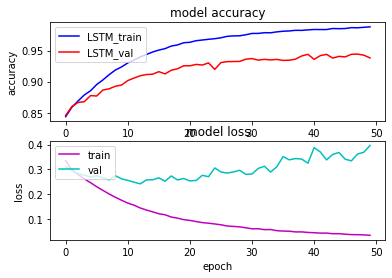

In [27]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

## GloVe2word2vec - Embeddings

In [28]:
glove_filename = './datos/glove.6B.100d.txt'

word2vec_output_file = glove_filename+'.word2vec'
glove2word2vec(glove_filename, word2vec_output_file)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_26472\3203449831.py:4: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_filename, word2vec_output_file)
2022-07-27 18:11:44,990 : INFO : loading projection weights from ./datos/glove.6B.100d.txt
2022-07-27 18:12:34,541 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from ./datos/glove.6B.100d.txt', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-07-27T18:12:34.541298', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}
2022-07-27 18:12:34,547 : INFO : converting 400000 vectors from ./datos/glove.6B.100d.txt to ./datos/glove.6B.100d.txt.word2vec
2022-07-27 18:12:34,934 : INFO : storing 400000x100 projection weights into ./datos/glove.

(400000, 100)

In [29]:
# load the Stanford GloVe model
word2vec_output_file = glove_filename+'.word2vec'
embedding = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)

2022-07-27 18:13:17,730 : INFO : loading projection weights from ./datos/glove.6B.100d.txt.word2vec
2022-07-27 18:14:09,995 : INFO : KeyedVectors lifecycle event {'msg': 'loaded (400000, 100) matrix of type float32 from ./datos/glove.6B.100d.txt.word2vec', 'binary': False, 'encoding': 'utf8', 'datetime': '2022-07-27T18:14:09.995713', 'gensim': '4.2.0', 'python': '3.10.5 (tags/v3.10.5:f377153, Jun  6 2022, 16:14:13) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22000-SP0', 'event': 'load_word2vec_format'}


In [30]:
def glove_sentence_to_embedding(sentence: str) -> np.array:
    """
    Returns the element-wise mean of the embeddings that represent each word in a sentence
    """
    words = preprocessing(sentence)
    vector = np.zeros(embedding.vector_size)
    counter = 0
    for word in words:
        try:
            vector += embedding.get_vector(word)
            counter += 1
        except Exception as e:
            pass
    if counter > 0:
        vector = vector / counter
    return vector

In [31]:
y_sample = sentences['hatespeech'].astype(float)
X_sample = sentences['text'].astype(str)

X_train_validation, X_test, y_train_validation, y_test = train_test_split(X_sample.values, 
                                                    y_sample.values, 
                                                    random_state=42,test_size=0.2)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_validation, 
                                                    y_train_validation, 
                                                    random_state=42,test_size=0.125)

print('Number of rows in the total set: {}'.format(X_sample.shape[0]))
print('Number of rows in the training set: {}'.format(X_train.shape[0]))
print('Number of rows in the validation set: {}'.format(X_validation.shape[0]))
print('Number of rows in the test set: {}'.format(X_test.shape[0]))

Number of rows in the total set: 135556
Number of rows in the training set: 94888
Number of rows in the validation set: 13556
Number of rows in the test set: 27112


In [32]:
X_train = pd.DataFrame(X_train, columns=['data']).data.apply(glove_sentence_to_embedding)
X_validation = pd.DataFrame(X_validation, columns=['data']).data.apply(glove_sentence_to_embedding)
X_test = pd.DataFrame(X_test, columns=['data']).data.apply(glove_sentence_to_embedding)

In [33]:
# Create the classification model
glove_model = Sequential()
glove_model.add(Dense(100, activation='relu'))
glove_model.add(Dense(75, activation='relu'))
glove_model.add(Dense(50, activation='relu'))
glove_model.add(Dense(25, activation='relu'))
glove_model.add(Dense(1, activation='sigmoid'))

In [34]:
# Compile the model
glove_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# Train the model
glove_history = glove_model.fit(x=np.asarray(X_train.to_list()).astype('float32'),
                    y=y_train, 
                    batch_size=32, 
                    epochs=50,
                    validation_data=(np.asarray(X_validation.to_list()).astype('float32'), y_validation),
                    shuffle=True)

Epoch 1/50
2966/2966 [==============================] - 14s 4ms/step - loss: 0.3834 - accuracy: 0.8235 - val_loss: 0.3507 - val_accuracy: 0.8339
Epoch 2/50
2966/2966 [==============================] - 13s 4ms/step - loss: 0.3373 - accuracy: 0.8385 - val_loss: 0.3398 - val_accuracy: 0.8383
Epoch 3/50
2966/2966 [==============================] - 16s 6ms/step - loss: 0.3225 - accuracy: 0.8445 - val_loss: 0.3253 - val_accuracy: 0.8431
Epoch 4/50
2966/2966 [==============================] - 17s 6ms/step - loss: 0.3127 - accuracy: 0.8490 - val_loss: 0.3231 - val_accuracy: 0.8442
Epoch 5/50
2966/2966 [==============================] - 12s 4ms/step - loss: 0.3045 - accuracy: 0.8538 - val_loss: 0.3388 - val_accuracy: 0.8443
Epoch 6/50
2966/2966 [==============================] - 18s 6ms/step - loss: 0.2962 - accuracy: 0.8573 - val_loss: 0.3261 - val_accuracy: 0.8545
Epoch 7/50
2966/2966 [==============================] - 19s 6ms/step - loss: 0.2881 - accuracy: 0.8625 - val_loss: 0.3316 - val_ac

In [36]:
glove_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 75)                7575      
                                                                 
 dense_7 (Dense)             (None, 50)                3800      
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 22,776
Trainable params: 22,776
Non-trainable params: 0
_________________________________________________________________


In [37]:
emddng = np.asarray(X_test.to_list()).astype('float32')
pred = glove_model.predict(emddng, batch_size=100, verbose=1)
report = classification_report(y_test, pred.round())  
print(report)
tn, fp, fn, tp = confusion_matrix(y_test, pred.round()).ravel()
(tn,fp,fn,tp)

272/272 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

         0.0       0.93      0.91      0.92     15104
         1.0       0.89      0.91      0.90     12008

    accuracy                           0.91     27112
   macro avg       0.91      0.91      0.91     27112
weighted avg       0.91      0.91      0.91     27112



(13721, 1383, 1028, 10980)

In [38]:
accr = glove_model.evaluate(np.asarray(X_test.to_list()).astype('float32'), y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

848/848 [==============================] - 4s 4ms/step - loss: 0.3297 - accuracy: 0.9111
Test set
  Loss: 0.330
  Accuracy: 0.911


In [39]:
def glove_prediction(text: str, model: bin) -> str:
    emddng = np.asarray([glove_sentence_to_embedding(text).tolist()]).astype('float32')
    pred = model.predict(emddng, verbose=1)
    result = 'Hate Speech' if pred > 0.5 else 'Not Hate Speech'
    print(text, ' | ', result, ' | ', pred)
    return result

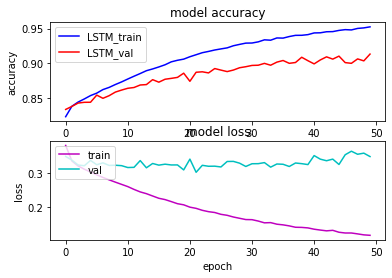

In [40]:
s, (at, al) = plt.subplots(2,1)
at.plot(glove_history.history['accuracy'], c= 'b')
at.plot(glove_history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(glove_history.history['loss'], c='m')
al.plot(glove_history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [41]:
glove_prediction('i hate you', glove_model)
glove_prediction('i love you', glove_model)
glove_prediction('i owe you', glove_model)
glove_prediction('You got bitch slapped with your own source', glove_model)
glove_prediction('stupid bitch', glove_model)
glove_prediction('you will die right now', glove_model)

1/1 [==============================] - 0s 118ms/step
i hate you  |  Hate Speech  |  [[0.99978197]]
1/1 [==============================] - 0s 99ms/step
i love you  |  Not Hate Speech  |  [[9.750258e-08]]
1/1 [==============================] - 0s 103ms/step
i owe you  |  Not Hate Speech  |  [[2.489011e-09]]
1/1 [==============================] - 0s 80ms/step
You got bitch slapped with your own source  |  Hate Speech  |  [[0.9989683]]
1/1 [==============================] - 0s 86ms/step
stupid bitch  |  Not Hate Speech  |  [[0.37899277]]
1/1 [==============================] - 0s 72ms/step
you will die right now  |  Not Hate Speech  |  [[0.00134313]]


'Not Hate Speech'

In [42]:
glove_model.save('salida/embedding_glove')

INFO:tensorflow:Assets written to: salida/embedding_glove\assets


2022-07-27 18:28:33,948 : INFO : Assets written to: salida/embedding_glove\assets


In [43]:
loaded_model = load_model('salida/embedding_glove')

In [44]:
glove_prediction('i hate you', loaded_model)
glove_prediction('i love you', loaded_model)
glove_prediction('i owe you', loaded_model)
glove_prediction('You got bitch slapped with your own source', loaded_model)
glove_prediction('get away from here stupid bitch', loaded_model)
glove_prediction('you will die sooner or later', loaded_model)

1/1 [==============================] - 1s 568ms/step
i hate you  |  Hate Speech  |  [[0.99978197]]
1/1 [==============================] - 0s 240ms/step
i love you  |  Not Hate Speech  |  [[9.750258e-08]]
1/1 [==============================] - 0s 118ms/step
i owe you  |  Not Hate Speech  |  [[2.489011e-09]]
1/1 [==============================] - 0s 281ms/step
You got bitch slapped with your own source  |  Hate Speech  |  [[0.9989683]]
1/1 [==============================] - 0s 145ms/step
get away from here stupid bitch  |  Hate Speech  |  [[0.9153121]]
1/1 [==============================] - 0s 270ms/step
you will die sooner or later  |  Not Hate Speech  |  [[0.33851787]]


'Not Hate Speech'